In [4]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

In [5]:
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

# Mean Pooling on Vertices in a 3D model

In this report I attempt to run a mean pooling function on the vertices of a 3D model. The attribution for this model goes to ferrumiron6 with his model human-foot-base-mesh.

Let's load the data into this report.

## Import Data

In [6]:
df = pd.read_csv("../data/vertexcoordinates.csv")
df.head()

,Name,Vertex_Index,X,Y,Z
0,Cube,0,0.059608,0.047925,0.383419
1,Cube,1,-0.030599,0.020009,-0.016010
2,Cube,2,0.052395,-0.102574,0.402345
3,Cube,3,0.049393,0.022423,-0.015811
4,Cube,4,-0.061567,0.066727,0.421855


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          800 non-null    object 
 1   Vertex_Index  800 non-null    int64  
 2   X             800 non-null    float64
 3   Y             800 non-null    float64
 4   Z             800 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 31.4+ KB


Here we see that we have no null values in this dataset, with a total of 800 vertices.

In theory, the coordinates for these vertices should corresponds to points in space, and to confirm that we have loaded our data accurately, lets plot some charts. We start with 3 point charts for each combination of our columns, X-Y, X-Z and Y-Z.

In [8]:
# Create the point chart between X and Y
xy_point = alt.Chart(df).mark_point().encode(
    x = alt.X('X').scale(domain=[-0.4,0.4]),
    y= alt.Y('Y').scale(domain=[-0.8,0.2])
).properties(
    width = 250,
    height = 350
)

# Create the point chart between X and Z
xz_point = alt.Chart(df).mark_point().encode(
    x = alt.X('X').scale(domain=[-0.4,0.4]),
    y= alt.Y('Z').scale(domain=[-0.1,0.8])
).properties(
    width = 250,
    height = 300
)

# Create the point chart between Y and Z
yz_point = alt.Chart(df).mark_point().encode(
    x = alt.X('Y').scale(domain=[-0.8,0.2]),
    y= alt.Y('Z').scale(domain=[-0.1,0.8])
).properties(
    width = 400,
    height = 300
)

In [9]:
vertex_point = (xz_point | yz_point) & xy_point
vertex_point

c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\User

alt.VConcatChart(...)

We observe that our vertices indeed do capture the general shape of our foot. Lets see what these points look like on a 3D chart.

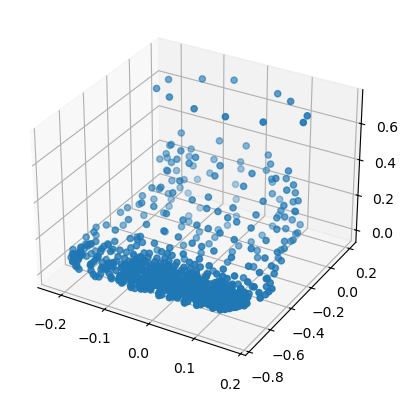

In [11]:
foot_fig_orig = plt.figure().add_subplot(projection='3d')
foot_fig_orig.scatter(df['X'], df['Y'], df['Z'])

## Converting to Numpy Array

Converting our 3D scene to a numpy array requires some thinking on how best to approach. Lets start by assessing what we would like our end goal to be here. I would like the output of the mean pooling funtion to move a specific sized cube as a window across our entire scene, replacing each of our points in the scene with the center of mass of the cube, effectively reducing the mesh density of our object. The smaller our cube is, the more generalized our object would become, while a larger window would result in greater compression.

In order to do this, I will need to create a 3x3 numpy array that encapsulates the entire scene.

Given the precicion of each of our vertices, I will need to decide a decimal point cutoff, so as to minimize the amount of memory we use.

Then, I will need to initialize my array with each of the vertices containing 1, and all others containing 0. Let's start by creating this array. To begin, lets round off our data points to 3 decimal points.

In [7]:
# Round data points to 3 decimals

df_round = df.round(3)
df_round.head()

,Name,Vertex_Index,X,Y,Z
0,Cube,0,0.060,0.048,0.383
1,Cube,1,-0.031,0.020,-0.016
2,Cube,2,0.052,-0.103,0.402
3,Cube,3,0.049,0.022,-0.016
4,Cube,4,-0.062,0.067,0.422


Let's drop our `Name` column and convert the `Vertex_Index` column to be the index of our dataframe.

In [8]:
df_round = df_round.drop(columns = ['Name'])
df_round = df_round.set_index('Vertex_Index')
df_round.head()

,X,Y,Z
Vertex_Index,,,
0,0.060,0.048,0.383
1,-0.031,0.020,-0.016
2,0.052,-0.103,0.402
3,0.049,0.022,-0.016
4,-0.062,0.067,0.422


Now lets convert to integer numbers.

In [9]:
df_round = df_round*1000
df_round = df_round.astype(int)
df_round.head()

,X,Y,Z
Vertex_Index,,,
0,60,48,383
1,-31,20,-16
2,52,-103,402
3,49,22,-16
4,-62,67,422


Now we can use these amended coordinates to create our numpy array.

I'm sure there is a more eloquent way to do this, but for simplicity let's brute force our way to this solution. First thing we need is the upper and lower bound of our array. We find the max and min of each coordinate in our dataframe.

In [10]:
df_round.describe()

,X,Y,Z
count,800.000000,800.000000,800.000000
mean,-1.867500,-533.118750,89.093750
std,97.607679,221.362053,112.237021
min,-225.000000,-762.000000,-16.000000
25%,-78.000000,-671.000000,35.000000
50%,0.000000,-614.000000,59.000000
75%,84.250000,-532.500000,91.250000
max,181.000000,197.000000,730.000000


We need to shift our values by the min, such that the smallest point in our array is at 0,0,0.

In [11]:
df_round_shifted = df_round.copy()

# Shift the X coordinate-->
df_round_shifted['X'] = df_round_shifted['X'] + abs(df_round_shifted['X'].min())

# Shift the Y coordinate-->
df_round_shifted['Y'] = df_round_shifted['Y'] + abs(df_round_shifted['Y'].min())

# Shift the Z coordinate-->
df_round_shifted['Z'] = df_round_shifted['Z'] + abs(df_round_shifted['Z'].min())

df_round_shifted.head()

,X,Y,Z
Vertex_Index,,,
0,285,810,399
1,194,782,0
2,277,659,418
3,274,784,0
4,163,829,438


Looking at our shifted values now, we can get an upper bound on the required size of our array.

In [12]:
df_round_shifted.describe()

,X,Y,Z
count,800.000000,800.000000,800.000000
mean,223.132500,228.881250,105.093750
std,97.607679,221.362053,112.237021
min,0.000000,0.000000,0.000000
25%,147.000000,91.000000,51.000000
50%,225.000000,148.000000,75.000000
75%,309.250000,229.500000,107.250000
max,406.000000,959.000000,746.000000


Let's create an array of zeroes corresponding to this size.

In [13]:
vertex_arr = np.zeros((407,960,747)) # We add 1 due to indexing in python starting from 0
vertex_arr

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [14]:
# Convert individual vertex coordinates to tuple
vertices = df_round_shifted.apply(lambda i: tuple(i), axis=1)

# Create list of tuples
vertices = vertices.tolist()
vertices

[(285, 810, 399),
 (194, 782, 0),
 (277, 659, 418),
 (274, 784, 0),
 (163, 829, 438),
 (132, 665, 38),
 (128, 610, 466),
 (343, 770, 25),
 (195, 691, 24),
 (270, 694, 8),
 (219, 602, 450),
 (168, 585, 470),
 (194, 874, 4),
 (258, 621, 17),
 (210, 894, 409),
 (263, 883, 398),
 (339, 838, 27),
 (279, 869, 11),
 (337, 753, 427),
 (323, 692, 407),
 (92, 665, 450),
 (94, 750, 474),
 (114, 847, 8),
 (111, 748, 13),
 (300, 622, 21),
 (340, 682, 21),
 (169, 615, 33),
 (204, 620, 25),
 (347, 785, 295),
 (64, 738, 320),
 (212, 583, 398),
 (348, 666, 287),
 (121, 601, 420),
 (364, 735, 289),
 (195, 906, 302),
 (156, 574, 434),
 (59, 687, 335),
 (256, 899, 300),
 (269, 616, 364),
 (103, 789, 329),
 (349, 327, 135),
 (393, 300, 25),
 (81, 315, 201),
 (96, 300, 16),
 (168, 260, 9),
 (163, 313, 199),
 (251, 263, 5),
 (225, 319, 174),
 (328, 270, 4),
 (274, 318, 168),
 (30, 317, 25),
 (32, 303, 141),
 (220, 474, 280),
 (216, 401, 223),
 (265, 411, 210),
 (265, 482, 257),
 (334, 415, 172),
 (312, 507, 

And now, lets fill our array with 1's wherever we have coordinates for a vertex in our object.

In [15]:
# For every vertex coordinate in the array, make it 1.
for v in vertices:
    i, j, k = v
    vertex_arr[i][j][k] = 1

Check to ensure that we have 800 points in our array -->

In [16]:
np.sum(vertex_arr)

np.float64(800.0)

Good. Now we have an array containing data points for each of our vertices in our 3D object.

## Defining the CNN and Mean Pooling Function

Our Convolutional Neural Network (CNN) will work by moving a cube of a set size across our 3D object and returning the center of mass of each of the points in that cube. The center of mass is meant to be a representation of a single vertex that captures the information of all it's neighboring ones. This way, very dense parts of our 3D model should be compressed more than sparse parts.